# 📊 MURA Valid Set 分布分析 (Per-patient average)
這個 Notebook 分析 MURA `valid` 資料是否存在 distribution shift，會以「每位病患」為單位，將病患資料夾下所有影像平均，再進行統計分析與可視化。

In [55]:
import pandas as pd
import numpy as np
import os
from PIL import Image
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from torchvision import transforms
from sklearn.decomposition import PCA


In [56]:
# 修改為你的實際路徑
train_csv_path = r"C:\Users\Vivo\2025_medicalimage_and_AI\train_cluster_split.csv"
valid_csv_path = r"C:\Users\Vivo\2025_medicalimage_and_AI\valid_cluster_split.csv"
data_root = r"C:\Users\Vivo\2025_medicalimage_and_AI"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=1)
])


In [57]:
def get_patient_stats(csv_path, mode):
    df = pd.read_csv(csv_path, header=None, names=['path', 'label'])
    stats = []

    for _, row in tqdm(df.iterrows(), total=len(df)):
        study_rel_path, label = row['path'], row['label']
        study_path = os.path.join(data_root, study_rel_path)
        image_paths = glob(os.path.join(study_path, "*.png"))

        pixel_means = []
        pixel_stds = []

        for img_path in image_paths:
            img = Image.open(img_path).convert("L")
            img = transform(img)
            img_np = np.array(img).astype(np.float32) / 255.0
            pixel_means.append(img_np.mean())
            pixel_stds.append(img_np.std())

        patient_mean = np.mean(pixel_means)
        patient_std = np.mean(pixel_stds)
        body_part = study_rel_path.split("/")[2]

        stats.append({
            "body_part": body_part,
            "label": label,
            "mean": patient_mean,
            "std": patient_std,
            "mode": mode
        })

    return pd.DataFrame(stats)


In [58]:
df_train = get_patient_stats(train_csv_path, "train")
df_valid = get_patient_stats(valid_csv_path, "valid")

df_all = pd.concat([df_train, df_valid], ignore_index=True)
df_all.head()


100%|██████████| 2925/2925 [00:26<00:00, 111.77it/s]


,body_part,label,mean,std,mode
0,XR_ELBOW,0,0.093839,0.128595,train
1,XR_ELBOW,0,0.159855,0.150744,train
2,XR_ELBOW,0,0.158649,0.182265,train
3,XR_ELBOW,0,0.227376,0.089082,train
4,XR_ELBOW,0,0.160057,0.139901,train


## 📊 Cell 5：畫出 Global 平均亮度 + 對比度 分佈

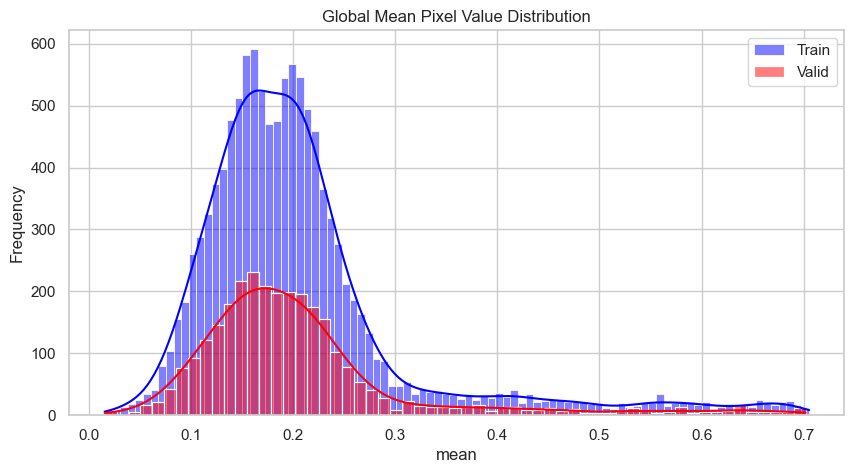

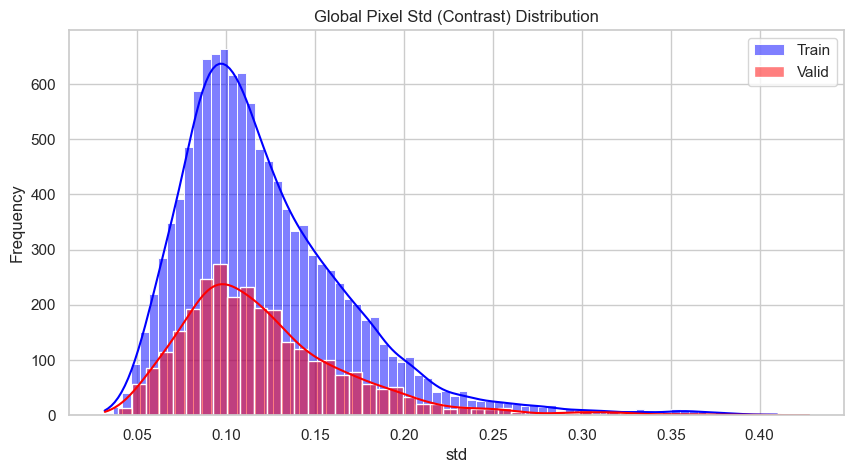

In [51]:
def plot_global_distribution(df, value_column, title):
    plt.figure(figsize=(10, 5))

    sns.histplot(df[df["mode"] == "train"][value_column], color='blue', label='Train', kde=True, alpha=0.5)
    sns.histplot(df[df["mode"] == "valid"][value_column], color='red', label='Valid', kde=True, alpha=0.5)

    plt.title(f"Global {title}")
    plt.xlabel(value_column)
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True)
    plt.show()

# 平均亮度
plot_global_distribution(df_all, "mean", "Mean Pixel Value Distribution")

# 對比度
plot_global_distribution(df_all, "std", "Pixel Std (Contrast) Distribution")


## 📉 Cell 6：PCA 視覺化（降到 2D）

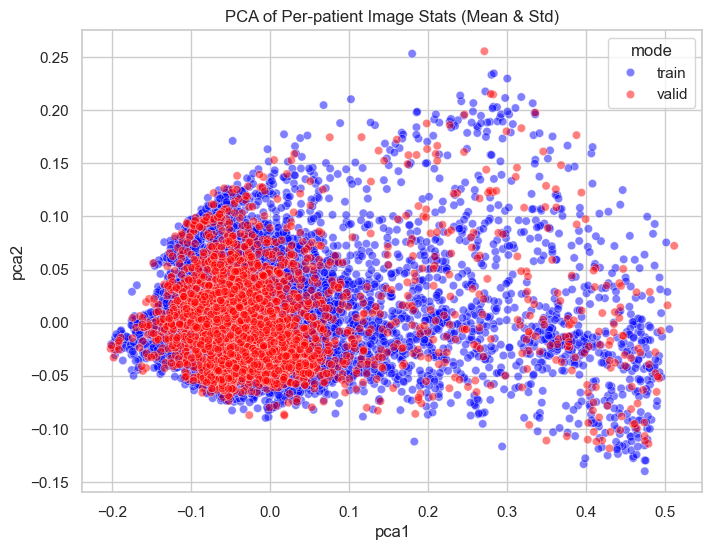

In [52]:
def plot_pca(df):
    pca = PCA(n_components=2)
    features = df[["mean", "std"]].values
    components = pca.fit_transform(features)
    df["pca1"] = components[:, 0]
    df["pca2"] = components[:, 1]

    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        x="pca1", y="pca2", hue="mode", data=df,
        palette={"train": "blue", "valid": "red"}, alpha=0.5
    )
    plt.title("PCA of Per-patient Image Stats (Mean & Std)")
    plt.grid(True)
    plt.show()

plot_pca(df_all.copy())


## 檢查bodt part正確讀取

In [53]:
print(df_all.head())  # 打印 df_all 的前五行，检查内容

  body_part  label      mean       std   mode
0  XR_ELBOW      0  0.093839  0.128595  train
1  XR_ELBOW      0  0.159855  0.150744  train
2  XR_ELBOW      0  0.158649  0.182265  train
3  XR_ELBOW      0  0.160057  0.139901  train
4  XR_ELBOW      0  0.167741  0.153978  train


## 🧠 Cell 7：依 body part 畫圖（亮度 & 對比度）



📊 XR_ELBOW - Mean Pixel Value Stats:
Train   - n: 1530, mean: 0.2014, std: 0.0961
Valid   - n: 382, mean: 0.1985, std: 0.1017

📊 XR_FINGER - Mean Pixel Value Stats:
Train   - n: 1690, mean: 0.2061, std: 0.1311
Valid   - n: 420, mean: 0.2015, std: 0.1302

📊 XR_FOREARM - Mean Pixel Value Stats:
Train   - n: 810, mean: 0.1803, std: 0.0963
Valid   - n: 200, mean: 0.1784, std: 0.0932

📊 XR_HAND - Mean Pixel Value Stats:
Train   - n: 1750, mean: 0.1722, std: 0.0794
Valid   - n: 435, mean: 0.1702, std: 0.0691

📊 XR_HUMERUS - Mean Pixel Value Stats:
Train   - n: 583, mean: 0.1936, std: 0.1196
Valid   - n: 144, mean: 0.2015, std: 0.1258

📊 XR_SHOULDER - Mean Pixel Value Stats:
Train   - n: 2413, mean: 0.2589, std: 0.1136
Valid   - n: 602, mean: 0.2574, std: 0.1156

📊 XR_WRIST - Mean Pixel Value Stats:
Train   - n: 2960, mean: 0.2061, std: 0.1061
Valid   - n: 737, mean: 0.2062, std: 0.1101


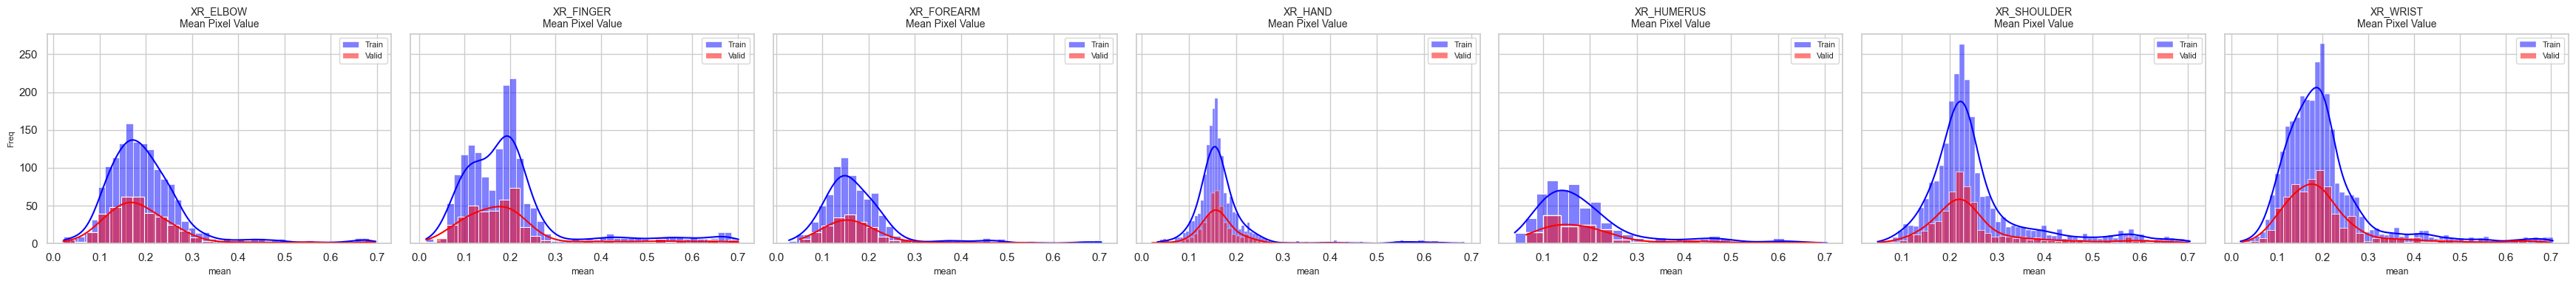


📊 XR_ELBOW - Pixel Std (Contrast) Stats:
Train   - n: 1530, mean: 0.1208, std: 0.0490
Valid   - n: 382, mean: 0.1187, std: 0.0445

📊 XR_FINGER - Pixel Std (Contrast) Stats:
Train   - n: 1690, mean: 0.1288, std: 0.0561
Valid   - n: 420, mean: 0.1311, std: 0.0599

📊 XR_FOREARM - Pixel Std (Contrast) Stats:
Train   - n: 810, mean: 0.1231, std: 0.0503
Valid   - n: 200, mean: 0.1207, std: 0.0490

📊 XR_HAND - Pixel Std (Contrast) Stats:
Train   - n: 1750, mean: 0.0956, std: 0.0406
Valid   - n: 435, mean: 0.0952, std: 0.0424

📊 XR_HUMERUS - Pixel Std (Contrast) Stats:
Train   - n: 583, mean: 0.1434, std: 0.0523
Valid   - n: 144, mean: 0.1478, std: 0.0533

📊 XR_SHOULDER - Pixel Std (Contrast) Stats:
Train   - n: 2413, mean: 0.1306, std: 0.0445
Valid   - n: 602, mean: 0.1271, std: 0.0422

📊 XR_WRIST - Pixel Std (Contrast) Stats:
Train   - n: 2960, mean: 0.1250, std: 0.0473
Valid   - n: 737, mean: 0.1247, std: 0.0485


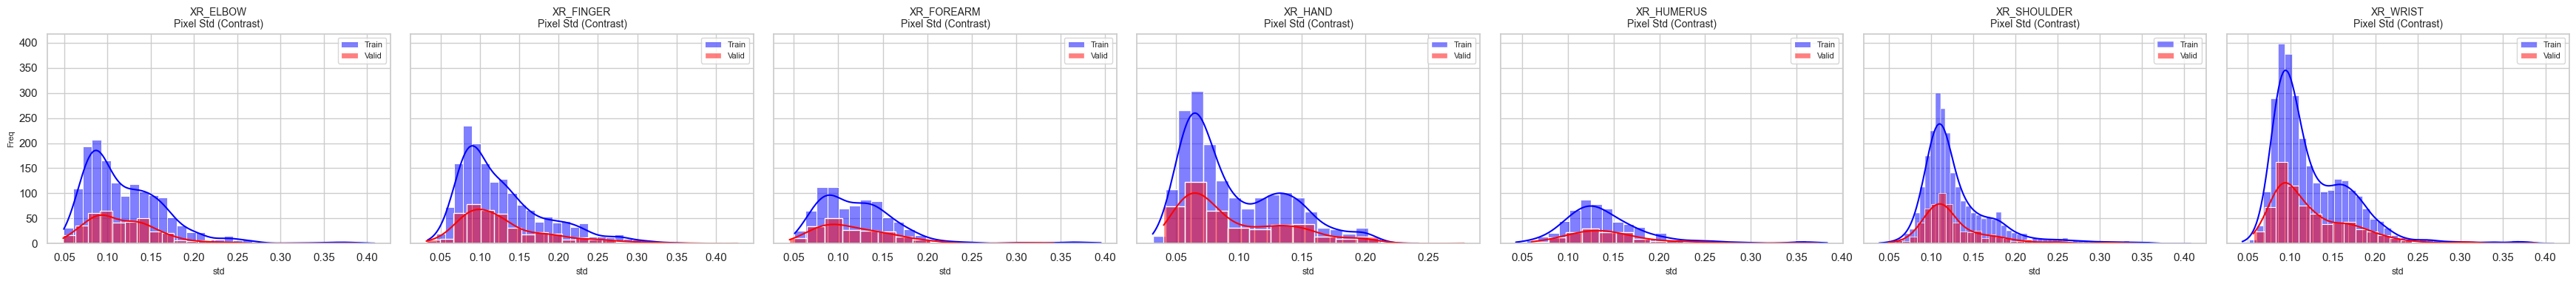

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_combined_distributions_row(df, value_column, title):
    body_parts = df["body_part"].unique()
    n = len(body_parts)
    
    fig, axes = plt.subplots(1, n, figsize=(5 * n, 4), sharey=True)

    for i, part in enumerate(body_parts):
        ax = axes[i]

        train_data = df[(df["mode"] == "train") & (df["body_part"] == part)][value_column]
        valid_data = df[(df["mode"] == "valid") & (df["body_part"] == part)][value_column]

        sns.histplot(train_data, color='blue', label='Train', kde=True, alpha=0.5, ax=ax)
        sns.histplot(valid_data, color='red', label='Valid', kde=True, alpha=0.5, ax=ax)

        ax.set_title(f"{part}\n{title}", fontsize=10)
        ax.set_xlabel(value_column, fontsize=9)
        ax.set_ylabel("Freq" if i == 0 else "", fontsize=8)
        ax.legend(fontsize=8)
        ax.grid(True)

        # 印出統計資訊
        print(f"\n📊 {part} - {title} Stats:")
        print(f"Train   - n: {len(train_data)}, mean: {train_data.mean():.4f}, std: {train_data.std():.4f}")
        print(f"Valid   - n: {len(valid_data)}, mean: {valid_data.mean():.4f}, std: {valid_data.std():.4f}")

    plt.tight_layout()
    plt.show()
# 畫 Mean 的分佈圖 (每個 body part 一張橫排圖 + 統計)
plot_combined_distributions_row(df_all, "mean", "Mean Pixel Value")

# 畫 Std 的分佈圖 (每個 body part 一張橫排圖 + 統計)
plot_combined_distributions_row(df_all, "std", "Pixel Std (Contrast)")


## 📉 Cell 7：針對part PCA 視覺化（降到 2D）

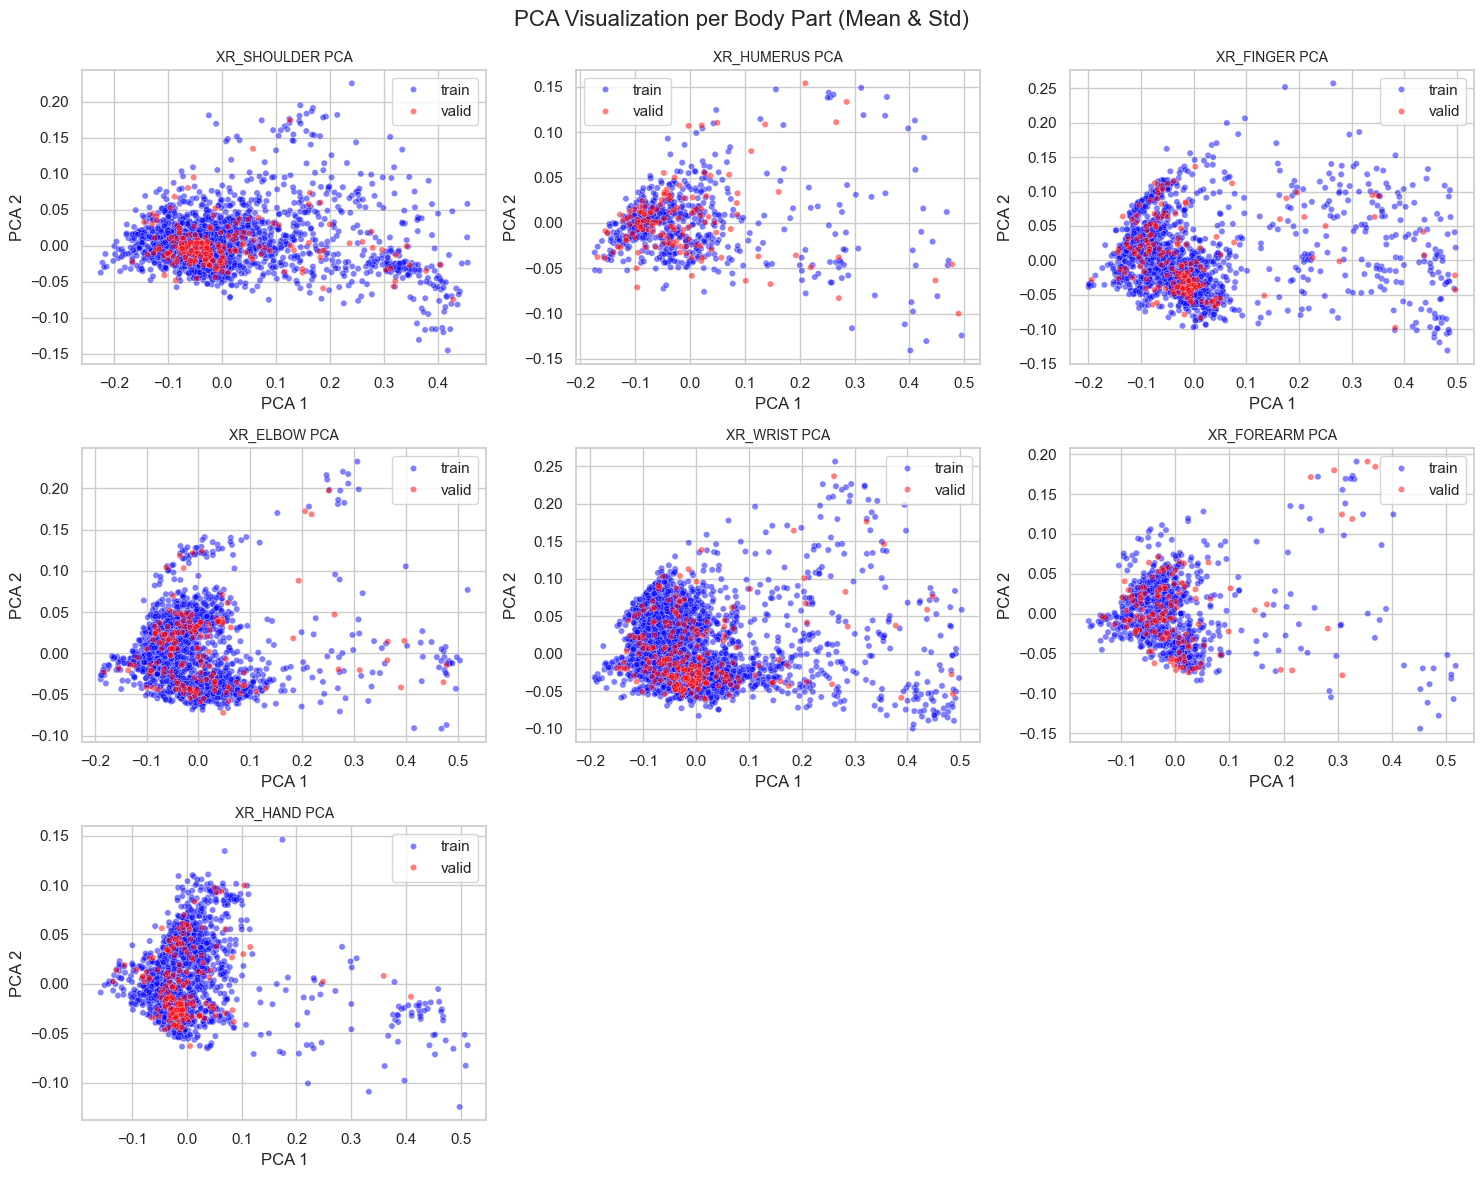

In [40]:
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

def plot_all_pca_grid(df, cols=3):
    unique_parts = df["body_part"].unique()
    n_parts = len(unique_parts)
    rows = (n_parts + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
    axes = axes.flatten()

    for i, part in enumerate(unique_parts):
        part_df = df[df["body_part"] == part].copy()  # 避免 SettingWithCopyWarning

        # 只用 mean 和 std 做 PCA
        features = part_df[["mean", "std"]].values
        pca = PCA(n_components=2)
        components = pca.fit_transform(features)

        part_df["pca1"] = components[:, 0]
        part_df["pca2"] = components[:, 1]

        ax = axes[i]
        sns.scatterplot(
            x="pca1", y="pca2", hue="mode", data=part_df,
            palette={"train": "blue", "valid": "red"}, alpha=0.5, ax=ax, s=20
        )
        ax.set_title(f"{part} PCA", fontsize=10)
        ax.set_xlabel("PCA 1")
        ax.set_ylabel("PCA 2")
        ax.grid(True)
        ax.legend().set_title("")  # legend 去掉 title

    # 清除多餘 subplot（如果有的話）
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle("PCA Visualization per Body Part (Mean & Std)", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    plt.show()
plot_all_pca_grid(df_all)
